In [1]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.7 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from xgboost import XGBClassifier

In [3]:
# Loading CSV files
df_train = pd.read_csv("UNSW_NB15_training-set.csv")
df_test = pd.read_csv("UNSW_NB15_testing-set.csv")

In [4]:
# Combining training and testing datasets for full analysis
df = pd.concat([df_train, df_test], ignore_index=True)
print("Dataset Loaded: ", df.shape)
df.head()

Dataset Loaded:  (257673, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
df[df['label']==1].head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
47911,47912,0.000009,ddp,-,INT,2,0,200,0,111111.1072,...,1,4,0,0,0,2,4,0,Backdoor,1
47912,47913,0.000009,ipv6-frag,-,INT,2,0,200,0,111111.1072,...,2,7,0,0,0,2,7,0,Backdoor,1
47913,47914,0.000009,cftp,-,INT,2,0,200,0,111111.1072,...,1,6,0,0,0,1,6,0,Backdoor,1
47914,47915,0.000003,wsn,-,INT,2,0,200,0,333333.3215,...,2,7,0,0,0,2,6,0,Backdoor,1
47915,47916,0.000008,pvp,-,INT,2,0,200,0,125000.0003,...,1,4,0,0,0,11,4,0,Backdoor,1


In [6]:
# Selecting relevant features
features = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate']

In [7]:
df = df.dropna()
X = df[features]
y = df['label']
print("X Shape:", X.shape)
print("y Shape:", y.shape)

X Shape: (257673, 6)
y Shape: (257673,)


In [8]:
# Signature-Based IDS (Snort-Like Detection)
def detect_known_attacks(df):
    known_signatures = [
        {'dur': 0, 'spkts': 1},
        {'dpkts': 1000, 'sbytes': 50000}
    ]

    alerts = []
    predictions = []
    for index, row in df.iterrows():
        detected = 0
        for sig in known_signatures:
            if all(row.get(k, 0) == v for k, v in sig.items()):
                alerts.append(f"ALERT: Attack detected at row {index}")
                detected = 1
                break
        predictions.append(detected)
    return alerts, predictions

In [9]:
# Measuring execution time for Signature-based IDS
start_time = time.time()
alerts, signature_based_predictions = detect_known_attacks(df)
signature_based_time = time.time() - start_time
print(f"Signature-based IDS execution time: {signature_based_time:.4f} seconds")
print(f"Total number of alerts: {len(alerts)}")
print("First five alerts:")
print("\n".join(alerts[:5]))
print("Last five alerts:")
print("\n".join(alerts[-5:]))

Signature-based IDS execution time: 25.8696 seconds
Total number of alerts: 3539
First five alerts:
ALERT: Attack detected at row 57
ALERT: Attack detected at row 58
ALERT: Attack detected at row 938
ALERT: Attack detected at row 939
ALERT: Attack detected at row 3312
Last five alerts:
ALERT: Attack detected at row 257592
ALERT: Attack detected at row 257629
ALERT: Attack detected at row 257630
ALERT: Attack detected at row 257670
ALERT: Attack detected at row 257671


In [10]:
# Converting predictions to a Series
signature_based_predictions = pd.Series(signature_based_predictions)

# Computing confusion matrix for Signature-Based IDS
cm_sig = confusion_matrix(y, signature_based_predictions)
tn_sig, fp_sig, fn_sig, tp_sig = cm_sig.ravel()

false_negative_rate_sig = fn_sig / (fn_sig + tp_sig) if (fn_sig + tp_sig) > 0 else 0
false_positive_rate_sig = fp_sig / (fp_sig + tn_sig) if (fp_sig + tn_sig) > 0 else 0
sensitivity_sig = tp_sig / (tp_sig + fn_sig) if (tp_sig + fn_sig) > 0 else 0
specificity_sig = tn_sig / (tn_sig + fp_sig) if (tn_sig + fp_sig) > 0 else 0

print(f"Signature-Based IDS - False Negative Rate (Type I Error): {false_negative_rate_sig:.4f}")
print(f"Signature-Based IDS - False Positive Rate (Type II Error): {false_positive_rate_sig:.4f}")
print(f"Signature-Based IDS - Sensitivity (True Positive Rate): {sensitivity_sig:.4f}")
print(f"Signature-Based IDS - Specificity (True Negative Rate): {specificity_sig:.4f}")

Signature-Based IDS - False Negative Rate (Type I Error): 0.9999
Signature-Based IDS - False Positive Rate (Type II Error): 0.0378
Signature-Based IDS - Sensitivity (True Positive Rate): 0.0001
Signature-Based IDS - Specificity (True Negative Rate): 0.9622


In [11]:
# Computing ROC Curve for Signature-Based IDS
fpr_sig, tpr_sig, _ = roc_curve(y, signature_based_predictions)
roc_auc_sig = auc(fpr_sig, tpr_sig)

In [12]:
# Training XGBoost Anomaly-Based IDS

# Measure execution time for Anomaly-based IDS
start_time = time.time()

# Train XGBoost model for anomaly detection
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

y_pred = model.predict(X)
anomaly_based_time = time.time() - start_time

print("Classification Report:")
print(classification_report(y, y_pred))
print(f"Anomaly-based IDS execution time: {anomaly_based_time:.4f} seconds")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:51:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     93000
           1       0.95      0.95      0.95    164673

    accuracy                           0.93    257673
   macro avg       0.93      0.93      0.93    257673
weighted avg       0.93      0.93      0.93    257673

Anomaly-based IDS execution time: 3.8773 seconds


In [13]:
# Computing confusion matrix for Anomaly-Based IDS
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

false_negative_rate = fn / (fn + tp)
false_positive_rate = fp / (fp + tn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Anomaly-Based IDS - False Negative Rate (Type I Error): {false_negative_rate:.4f}")
print(f"Anomaly-Based IDS - False Positive Rate (Type II Error): {false_positive_rate:.4f}")
print(f"Anomaly-Based IDS - Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Anomaly-Based IDS - Specificity (True Negative Rate): {specificity:.4f}")

Anomaly-Based IDS - False Negative Rate (Type I Error): 0.0531
Anomaly-Based IDS - False Positive Rate (Type II Error): 0.0951
Anomaly-Based IDS - Sensitivity (True Positive Rate): 0.9469
Anomaly-Based IDS - Specificity (True Negative Rate): 0.9049


In [14]:
# Computing ROC Curve for Anomaly-Based IDS
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

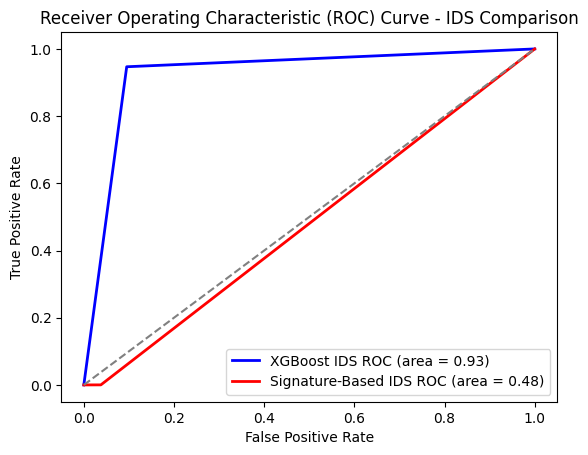

In [15]:
# Plot ROC Curve for both IDSs
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost IDS ROC (area = {roc_auc:.2f})')
plt.plot(fpr_sig, tpr_sig, color='red', lw=2, label=f'Signature-Based IDS ROC (area = {roc_auc_sig:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - IDS Comparison")
plt.legend(loc="lower right")
plt.show()
